# Smart PMI Random Forest Pipeline

In [3]:
import numpy as np
import pandas as pd
import sys, os
import random
import re

from rdkit import Chem
from rdkit.Chem import PandasTools
from mordred import Calculator, descriptors

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Preprocessing

In [2]:
# -- helper functions
np.random.seed(42)
random.seed(42)

# -- get RDKit featurizers
descriptor_names = list(Chem.rdMolDescriptors.Properties.GetAvailableProperties())
get_descriptors = Chem.rdMolDescriptors.Properties(descriptor_names)
# -- get Mordred featurizers
calc = Calculator(descriptors, ignore_3D=True)

def smi_to_descriptors(smile):
    # -- RDK helper func
    mol = Chem.MolFromSmiles(smile)
    descriptors = []
    if mol:
        # -- use RDKit featurizers
        descriptors = np.array(get_descriptors.ComputeProperties(mol))
    return descriptors 

# -- apply molecular featurization on SMILES
def featurize(df, use_rdk = False, use_m = False):
    df = df.copy()
    smiles = df.SMILES
    append = [df]

    # -- use RDKit featurizers
    if use_rdk:
        rdkit_desc = list(df.SMILES.apply(smi_to_descriptors))
        desc_df = pd.DataFrame(rdkit_desc, columns=descriptor_names)
        append += [desc_df]
    # -- use Mordred featurizers
    if use_m:
        mols = [Chem.MolFromSmiles(smi) for smi in smiles if Chem.MolFromSmiles(smi) != None]
        # drop = ['SpAbs_Dt',	'SpMax_Dt'	,'SpDiam_Dt'	,'SpAD_Dt',	'SpMAD_Dt'	,'LogEE_Dt'	,'SM1_Dt'	,'VE1_Dt',	'VE2_Dt',
	    #         'VE3_Dt',	'VR1_Dt',	'VR2_Dt',	'VR3_Dt'	,'DetourIndex']
        mord_df = calc.pandas(mols) #.select_dtypes(include=['int64', 'float64'])
        append += [mord_df]
    
    return pd.concat(append, axis=1)

# -- find columns uncommon to dfs
def validate_cols(df1, df2):
    cols1, cols2 = df1.columns, df2.columns
    validate_cols = [feature for feature in cols1 if feature not in cols2]
    uncommon = set(cols1) ^ set(cols2)
    print('outlying features (empty is good):', uncommon)

In [3]:
# test imports : TODO: preprocess X

## get SMILES data from test AND Merck Model predictions
test_smi_path = './data/testdata.sdf'
test_smis = Chem.PandasTools.LoadSDF(test_smi_path, smilesName = 'SMILES')[['ID','SMILES']]

## get attrs from test
attr_path = './data/parsed_attributes.csv'
test_attr= pd.read_csv(attr_path)

## naming
test = pd.concat([test_smis, test_attr], ignore_index=False, axis=1)
true_test = [3.1, 3.0, 3.1, 3.3, 1.9,4.0, 3.1, 4.1, 3.4, 
            2.5, 3.5, 2.8, 4.2, 2.5, 3.9, 2.8, 2.9, 3.3,
            4.7, 3.9, 2.9, 4.3, 4.2, 2.9, 3.5, 4.4, 4.3, 3.2]
test['TRUE'] = true_test

In [4]:
# -- load training data [train_y, train_x]
train_path = './data/ci5001778_si_001.txt'
train = pd.read_csv(train_path).drop(['MOLECULE', 'Source', 'Votes'], axis=1)

## -- naming
train['meanComplexity'] = train.meanComplexity.apply(lambda x: np.round(x, decimals=3))
con_pre = [col.replace('DESCRIPTORCOMPLEXITY_','') for col in train.columns]
con_pre2 = [col.replace('SP3CARBONS_', '') for col in con_pre]
no_moe_cols = [col for col in con_pre2 if 'MOE_2D_' not in col]
## -- get rid of moe columns
train.columns = con_pre2

In [5]:
flag_nulls = featurize(train[no_moe_cols], True, True)
exclude = flag_nulls[flag_nulls.isna().any(axis=1)].index
trim = lambda df : df[~df.index.isin(exclude)]

[11:59:16] Explicit valence for atom # 14 N, 4, is greater than permitted
[11:59:17] Explicit valence for atom # 9 N, 4, is greater than permitted
[11:59:17] Explicit valence for atom # 22 N, 4, is greater than permitted
[11:59:17] Explicit valence for atom # 17 N, 4, is greater than permitted
[11:59:17] Explicit valence for atom # 26 N, 4, is greater than permitted
[11:59:17] Explicit valence for atom # 21 N, 4, is greater than permitted
[11:59:17] Explicit valence for atom # 11 N, 4, is greater than permitted
[11:59:17] Explicit valence for atom # 21 N, 4, is greater than permitted
[11:59:18] Explicit valence for atom # 8 N, 4, is greater than permitted
[11:59:18] Explicit valence for atom # 12 N, 4, is greater than permitted
[11:59:18] Explicit valence for atom # 7 N, 4, is greater than permitted
[11:59:18] Explicit valence for atom # 18 N, 4, is greater than permitted
[11:59:18] Explicit valence for atom # 28 N, 4, is greater than permitted
[11:59:18] Explicit valence for atom # 17

/Users/nicolelrtin/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 18%|█▊        | 303/1731 [00:15<01:59, 11.93it/s]

/Users/nicolelrtin/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 21%|██        | 362/1731 [00:19<01:32, 14.73it/s]

/Users/nicolelrtin/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 40%|████      | 697/1731 [00:40<00:58, 17.63it/s]

/Users/nicolelrtin/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 58%|█████▊    | 1009/1731 [01:00<00:47, 15.10it/s]

/Users/nicolelrtin/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 64%|██████▍   | 1110/1731 [01:07<00:38, 16.29it/s]

/Users/nicolelrtin/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 76%|███████▋  | 1320/1731 [01:27<01:52,  3.64it/s]

/Users/nicolelrtin/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 78%|███████▊  | 1346/1731 [01:29<00:50,  7.67it/s]

/Users/nicolelrtin/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1731/1731 [01:55<00:00, 14.94it/s]


## Train Test Split

In [7]:
# funky_cols = big_train.select_dtypes(exclude=['int64', 'float64']).columns
# big_train[funky_cols] = big_train[funky_cols].apply(pd.to_numeric, errors='coerce').fillna(np.mean).isna().sum()

In [8]:
# validate_cols(big_train, big_test)
# big_test[funky_cols] = big_test[funky_cols].apply(pd.to_numeric, errors='coerce').fillna(np.mean).isna().sum()


## Modeling

In [1]:
def rf_regress(x, rf = True, search = False, classify = False):
    # -- Pick model
    if rf:
        model = RandomForestRegressor(random_state=42) 
        # if not classify else RandomForestClassifier(random_state=42) 
    else:
        model = HistGradientBoostingRegressor(random_state=42, min_samples_leaf= 6,max_leaf_nodes= 5,max_depth= 6,l2_regularization= 1.5) 
        # if not classify else HistGradientBoostingClassifier(random_state=42) 
    
    if search:
        # -- Parameter Tuning
        random_grid = {}
        # Maximum number of levels in tree
        max_depth = [int(x) for x in np.linspace(3, 10, num = 3)]
        random_grid['max_depth'] = max_depth
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4, 6, 10]
        random_grid['min_samples_leaf'] = min_samples_leaf
    
        if rf:
            # Number of trees in random forest
            n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 10)]
            random_grid['n_estimators'] = n_estimators
            # Number of features to consider at every split
            max_features = ['auto', 'sqrt', 'log2']
            random_grid['max_features'] = max_features
            # Minimum number of samples required to split a node
            min_samples_split = [5, 10, 20, 30]
            random_grid['min_samples_split'] = min_samples_split
            # Method of selecting samples for training each tree
            bootstrap = [True, False]
            random_grid['bootstrap'] = bootstrap
        else:
            # Maximum number of leaves for each tree
            max_leaf_nodes = [3, 5, 10, 20, 30]
            random_grid['max_leaf_nodes'] = max_leaf_nodes
            # L2 Reg parameter
            l2_regularization = [0, 1.5,] # --ORIGINAL--
            # l2_regularization = [0,0.001, 0.01, 0,1, 0.5, 1, 1.5, 2, 2.5]
            random_grid['l2_regularization'] = l2_regularization
        
        model = RandomizedSearchCV(estimator = model, param_distributions = random_grid, # --ORIGINAL--
                                    n_iter = 40, cv = 3, verbose=2, random_state=42, n_jobs = -1) 
        # model = RandomizedSearchCV(estimator = model, param_distributions = random_grid,
        #                             n_iter = 45, verbose=2, random_state=42, n_jobs = -1) 

    # x = x.apply(lambda i: np.log10(i) if np.issubdtype(type(i), np.number) else i)
    model.fit(x[s:], train_y[s:])

    # print('model parameters', standard_model.get_params())
    print('...Validation...')
    pred = model.predict(x[:s])
    mae = mean_absolute_error(train_y[:s], pred)
    mse = mean_squared_error(train_y[:s], pred)
    rmse = mse**.5
    r2 = r2_score(train_y[:s], pred)
    scores = cross_val_score(model, x[:s], train_y[:s], scoring='r2', cv=5)
    
    print(' MAE', mae)
    print(' MSE', mse)
    print(' RMSE',rmse)
    print(' R^2', r2)
    print(' CV-R^2', scores)
    print(' avg CV-R^2', np.mean(scores))

    return {'MSE':mse, 'RMSE': rmse, 'R^2': r2, 'Predictions':pred, 'Model': model}


In [2]:
# print('\n no moe (baseline) .................')
# base = rf_regress(no_moe)

# train_x + rdkit + mordred
print('\n the whole enchilada (everything) ..')
everything = rf_regress(big_train, rf=False, search=False)


 the whole enchilada (everything) ..


NameError: name 'big_train' is not defined

In [ ]:
everything['Model']

HistGradientBoostingRegressor(l2_regularization=1.5, max_depth=6,
                              max_leaf_nodes=5, min_samples_leaf=6,
                              random_state=42)

## Test Evaluation (against Merck)

In [ ]:
poos = everything['Model'].predict(big_test)
mnm = pd.DataFrame({'idx':test.ID, 'GS Pred':poos, 
            'Merck Pred':test.PREDICTED, 'Trues':true_test}).set_index('idx').sort_values('Trues')

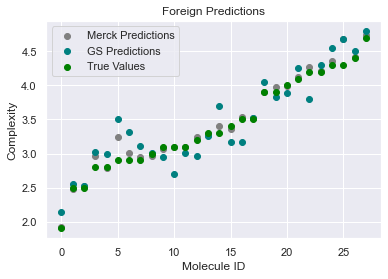

In [ ]:
plt.scatter(range(28), mnm['Merck Pred'], c='gray', label = 'Merck Predictions')
plt.scatter(range(28), mnm['GS Pred'], c='teal', label = 'GS Predictions')
plt.scatter(range(28), mnm['Trues'], c='green', label = 'True Values')
plt.xlabel('Molecule ID')
plt.ylabel('Complexity')
plt.title('Foreign Predictions')
plt.legend()

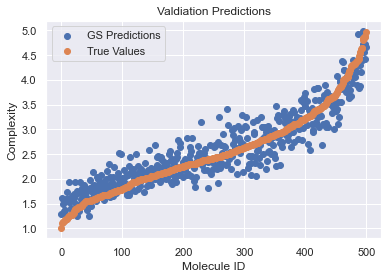

In [ ]:
mml = pd.DataFrame({'pred':everything['Predictions'], 'real':train_y[:s]}).sort_values('real')
plt.scatter(range(500), mml.pred, label='GS Predictions')
plt.scatter(range(500), mml.real, label = 'True Values')
plt.xlabel('Molecule ID')
plt.ylabel('Complexity')
plt.title('Valdiation Predictions')
plt.legend()

## Evaluation (Performance)

Text(0, 0.5, 'Predicted Complexity')

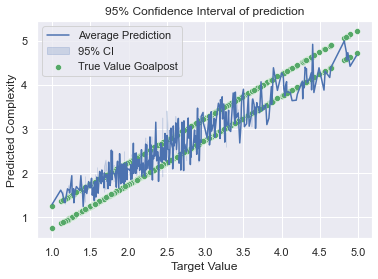

In [ ]:
best = everything['Predictions']
actual = train_y[:s]

db = pd.DataFrame({'real': actual, 'pred': best})
sns.lineplot(x = 'real', y='pred', data=db)

# reference green ranges
sns.scatterplot(x=actual, y=actual-0.25, color='g')
sns.scatterplot(x=actual, y=actual+0.25, color='g').set_title('95% Confidence Interval of prediction')
plt.legend(labels=['Average Prediction', '95% CI', 'True Value Goalpost'])
plt.xlabel('Target Value')
plt.ylabel('Predicted Complexity')

In [ ]:
diffs = actual - best

def cumulative(diffs):
    N = len(diffs)
    n_steps = 1000
    abs_diffs = abs(diffs)
    mn, mx = min(abs_diffs), max(abs_diffs)
    step = (mx - mn)/n_steps
    y = []
    x = []
    for i in range(n_steps):
        th = mn + i*step
        x += [th]
        y += [int(100*len(np.where(abs(abs_diffs) < th)[0])/len(diffs))]

    return x, y

/Users/nicolelrtin/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

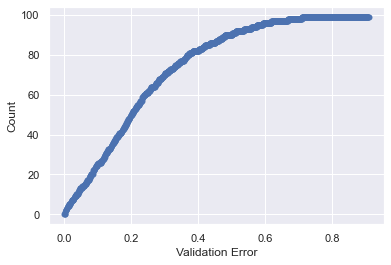

In [ ]:
dx, dy = cumulative(diffs)
sns.scatterplot(dx, dy, linewidth=0)
plt.xlabel('Validation Error')
plt.ylabel('Count')

Text(0.5, 0, 'Validation Error')

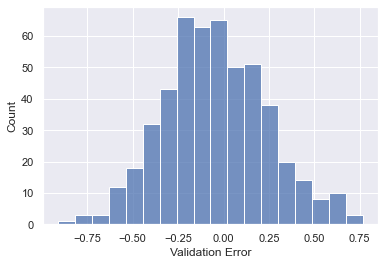

In [ ]:
db['diffs'] = diffs

sns.histplot(diffs)
plt.xlabel('Validation Error')

In [ ]:
# def errorbar(best):
#     rounded = pd.DataFrame({'pred': np.round(best * 2) / 2, 
#                         'actual': np.round(actual * 2) / 2})
#     round_group = rounded.groupby('actual').agg(['mean', 'std', 'mad'])
#     round_group.columns = round_group.columns.droplevel(0)
#     return round_group.rename_axis(None, axis=1).reset_index()

# errorbar(best)

Text(0, 0.5, 'Continuous Predicted Complexity')

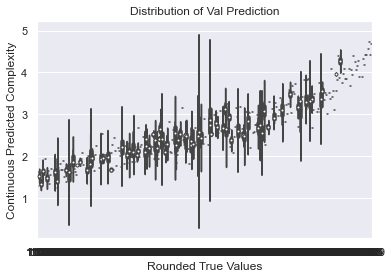

In [ ]:
# plt.violinplot(db.groupby('real')['pred'].apply(list).values,
#             positions = np.arange(1, 5.5, 0.5), 
#             showmeans=True)
sns.set_palette('Paired')
sns.violinplot(x='real', y='pred', data = db)
plt.title('Distribution of Val Prediction')
plt.xlabel('Rounded True Values')
plt.ylabel('Continuous Predicted Complexity')

In [ ]:
# !jupyter nbconvert --to pdf <filename>

## GS Test

In [ ]:
# pippa = ['BIC.sdf', 'FIL.sdf', 'FTC.sdf', 'RAN.sdf', 'SOF.sdf', 'Trodelvy drug linker.sdf', 'VEL.sdf', 'VOX.sdf']
pippa = ['AMB.sdf', 'COBI.sdf', 'EVG.sdf', 'GS-1156.sdf', 'GS-1427.sdf', 'GS-4224-03.sdf', 'GS-5290.sdf', 'TAF.sdf']
pippa_path = './data/Compound files/'

gs_smis = pd.DataFrame()

for file in pippa:
    gs_smis = pd.concat([gs_smis,PandasTools.LoadSDF(pippa_path + file, smilesName='SMILES').head(1)])
gs_smis['ID'] = pippa

gs_smis = gs_smis.reset_index(drop=True)

new = featurize(gs_smis, True, True).drop(['ID','SMILES','ROMol'],1)

[11:22:40] Warning: conflicting stereochemistry at atom 30 ignored. by rule 1a.
[11:22:40] Warning: conflicting stereochemistry at atom 30 ignored. by rule 1a.
100%|██████████| 8/8 [00:01<00:00,  4.05it/s]

/Users/nicolelrtin/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



/var/folders/xp/lyc8z_3n0tl80zxzzyy6h_n00000gn/T/ipykernel_97085/2764939462.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  new = featurize(gs_smis, True, True).drop(['ID','SMILES','ROMol'],1)


In [ ]:
mandeep = pd.read_csv('./data/parsed_attributes_moe.csv').drop('MOLECULE',1)

gs_test = pd.concat([mandeep,new], 1)[big_train.columns]
gs_smis['Predictions'] = np.round(everything['Model'].predict(gs_test),1)

/var/folders/xp/lyc8z_3n0tl80zxzzyy6h_n00000gn/T/ipykernel_97085/265109067.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  mandeep = pd.read_csv('./data/parsed_attributes_moe.csv').drop('MOLECULE',1)
/var/folders/xp/lyc8z_3n0tl80zxzzyy6h_n00000gn/T/ipykernel_97085/265109067.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  gs_test = pd.concat([mandeep,new], 1)[big_train.columns]


In [ ]:
# gs_smis = gs_smis.drop('ROMol',1)
gs_smis['MW'] = new['MW']
gs_smis['sPMI'] = (0.13 * gs_smis.MW) + (177 * gs_smis.Predictions) - 252
gs_smis['OLS'] = [0]*8
gs_smis['sPMI_OLS'] = (0.13 * gs_smis.MW) + (177 * gs_smis.OLS) - 252


In [ ]:
gs_smis[['ID', 'Predictions', 'sPMI', 'OLS', 'sPMI_OLS',]]

,ID,Predictions,sPMI,OLS,sPMI_OLS
0,AMB.sdf,3.3,381.260534,0,-202.839466
1,COBI.sdf,3.4,450.596145,0,-151.203855
2,EVG.sdf,3.0,337.126234,0,-193.873766
3,GS-1156.sdf,3.8,570.807049,0,-101.792951
4,GS-1427.sdf,3.8,512.670153,0,-159.929847
5,GS-4224-03.sdf,4.0,545.729075,0,-162.270925
6,GS-5290.sdf,3.8,517.607730,0,-154.992270
7,TAF.sdf,3.9,500.205182,0,-190.094818
